## It's good to be lazy :) ##
This is something I've been thinking about for a while now. My thinking is that we should be able to automate at least some part of the EDA process. This obviously will not completely replace all EDA work you need to do, nothing can do that; but at least it should save you some time doing mundane tasks.

LazyEDA is based on a couple of hours of work so it is still rough around the edges and there are still a ton of features I'd like to add, but I thought I might as well share early and see what sort of response I get. Comments and Pull Requests are more than welcome.

https://github.com/TareqAlKhatib/Lazy-EDA

A good part of LazyEDA's code is borrowed (shamelessly stolen) from the notebook below:
https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize

In [1]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

properties_2016.csv
sample_submission.csv
train_2016_v2.csv
zillow_data_dictionary.xlsx



I don't think we can wget code from the web so pasting the source code is the next best thing.

In [2]:
""" 
A Python Module to do automated Exploratory Data Analysis and some light weight data prep.
https://github.com/TareqAlKhatib/Lazy-EDA
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
def full_report(df, target_column=None):
	"""Tries to run every possible report on the provided dataframe"""
	display(HTML("<h1>Lazy EDA Report</h1>"))
	
	breakdown_date(df)
	show_dtypes(df)
	plot_nulls(df)
	plot_long_lat(df, target_column)
	if target_column is not None:
		plot_scatter_target(df, target_column)
		plot_hist_target(df, target_column)
		plot_correlations(df, target_column)            

def plot_correlations(df, target_column):
	display(HTML("<h2>Column Data Types</h2>"))
	display(HTML("<p>Below is a plot of the correlation coefficients of the dataframe's numeric columns and the target column</p>"))
	
	num_df = df.select_dtypes(include=numerics)
	del(num_df[target_column])
	num_df.corrwith(df[target_column]).sort_values(ascending=False).plot(
		kind='barh', figsize=(12,12), title="Correlation Coefficient with Target")
	plt.show()
	
def breakdown_date(df):
	"""
	Creates new columns in a dataframe representing the components of a date (year, month, day of year, & week day name)
	"""
	date_cols = df.dtypes[df.dtypes == 'datetime64[ns]'].index
	display(HTML("<h2>Breaking down date columns</h2>"))
	if len(date_cols) > 0:
		display(HTML("<p>The following columns will be broken down into year, month, day of year, and weekday columns</p> <ul>"))
		
		for date_column in date_cols:
			display(HTML("<li>{}</li>".format(date_column)))
			df['{}_year'.format(date_column)] = df[date_column].dt.year
			df['{}_month'.format(date_column)] = df[date_column].dt.month
			df['{}_dayofyear'.format(date_column)] = df[date_column].dt.dayofyear
			df['{}_weekday'.format(date_column)] = df[date_column].dt.weekday_name
		
		display(HTML("</ul>"))
	else:
		display(HTML("<p>No Date columns found to breakdown.</p>"))
		
	return df

def plot_nulls(df):
	"""
	Displays a horizontal bar chart representing the percentage of nulls in each column
	"""
	display(HTML("<h2>Plot Nulls</h2>"))
	
	null_percentage = df.isnull().sum()/df.shape[0]*100
	null_percentage_filtered = null_percentage[null_percentage > 0].sort_values()
	
	if len(null_percentage_filtered) > 0:
		display(HTML("<p>The plot below shows the percentage of NaNs in each column in the dataframe</p>"))
		null_percentage_filtered.plot(kind='barh', figsize=(12,12), title="Plot Null Percentages")
		plt.show()
		
	else:
		display(HTML("<p>The dataframe does not contain any missing data</p>"))
	return null_percentage_filtered

def show_dtypes(df):
	"""Shows the data types of all columns"""
	
	display(HTML("<h2>Column Data Types</h2>"))
	
	# Saving the old display max
	old_max = pd.options.display.max_rows
	pd.options.display.max_rows = len(df.columns)
	
	# Display DTypes
	dtype_df = pd.DataFrame({"Column Name": df.dtypes.index,"DType": df.dtypes.values})
	display(dtype_df)
	
	# Restoring the old display max
	pd.options.display.max_rows = old_max
	
def plot_scatter_target(df, target_column):
	"""Plots a sorted scatter plot of the values in a numerical target column"""
	display(HTML("<h2>Plot Scatter Target</h2>"))
	display(HTML("<p>Below is a sorted scatter plot of the values in the target column</p>"))
	
	plt.scatter(range(df[target_column].shape[0]), np.sort(df[target_column].values))
	plt.xlabel('index', fontsize=12)
	plt.ylabel(target_column, fontsize=12)
	plt.show()

def plot_hist_target(df, target_column):
	display(HTML("<h2>Plot Histogram Target</h2>"))
	display(HTML("<p>Below is a histogram of the values in the target column</p>"))
	
	# Filter 1st and 99th percentiles
	ulimit = np.percentile(df.logerror.values, 99)
	llimit = np.percentile(df.logerror.values, 1)
	df['tempTarget'] = df[target_column]
	df['tempTarget'].ix[df['tempTarget']>ulimit] = ulimit
	df['tempTarget'].ix[df['tempTarget']<llimit] = llimit
	
	# Plot
	plt.figure(figsize=(12,8))
	sns.distplot(df['tempTarget'])
	plt.xlabel(target_column, fontsize=12)
	plt.show()
	
	del[df['tempTarget']]
	
def plot_long_lat(df, target_column):
	if 'latitude' in df.columns.str.lower() and 'longitude' in df.columns.str.lower():
		display(HTML("<h2>Plot longitude/latitude</h2>"))
		display(HTML("<p>Below is a scatter plot of long/lat coordinate in the dataframe</p>"))
		
		plt.figure(figsize=(12,12))
		
		if target_column is None:
			sns.jointplot(x=df.latitude.values, y=df.longitude.values, size=10)
		else:
			df['tempTarget'] = (df['logerror'] - df['logerror'].min())/(df['logerror'].max() - df['logerror'].min())
			plt.scatter(x=df.latitude.values, y=df.longitude.values, c=df['tempTarget'].values)
			del(df['tempTarget'])
		plt.ylabel('Longitude', fontsize=12)
		plt.xlabel('Latitude', fontsize=12)
		plt.show()


Ideally, this is the only part you would have to worry about.

In [3]:
train_df = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("../input/properties_2016.csv", dtype={
    'hashottuborspa': 'object', 
    'propertycountylandusecode': 'object',
    'propertyzoningdesc': 'object',
    'fireplaceflag': 'object',
    'taxdelinquencyflag': 'object'
})

train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')

,Column Name,DType
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,airconditioningtypeid,float64
4,architecturalstyletypeid,float64
5,basementsqft,float64
6,bathroomcnt,float64
7,bedroomcnt,float64
8,buildingclasstypeid,float64
9,buildingqualitytypeid,float64


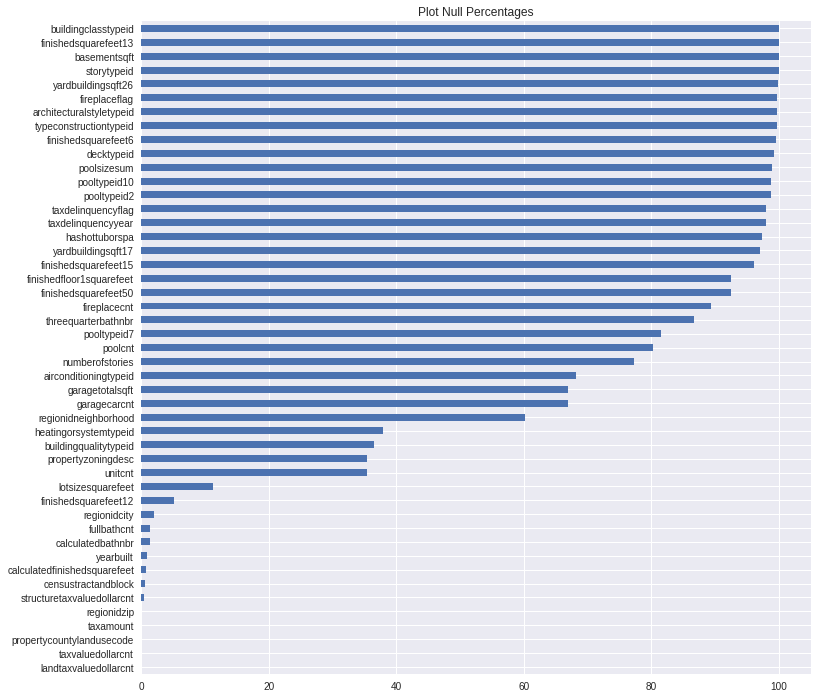

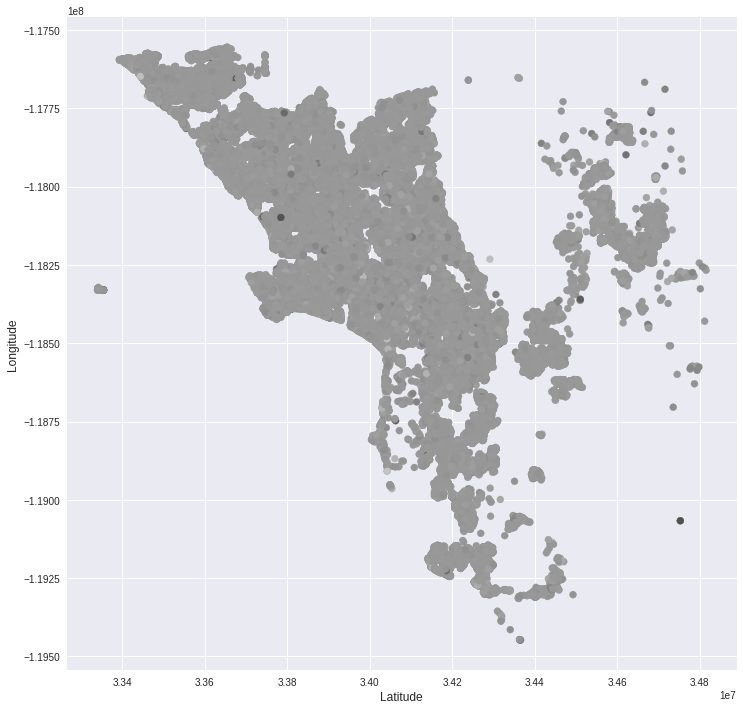

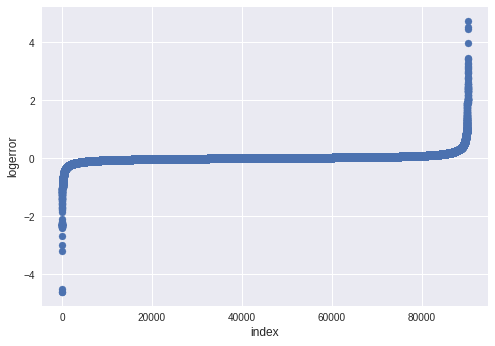

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:110: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


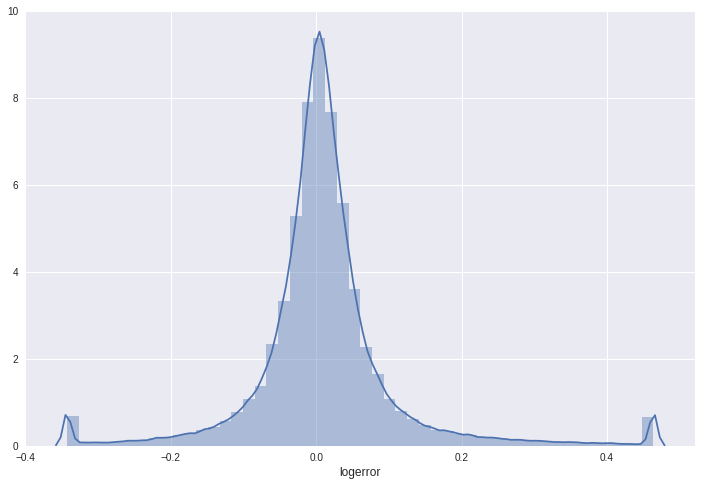

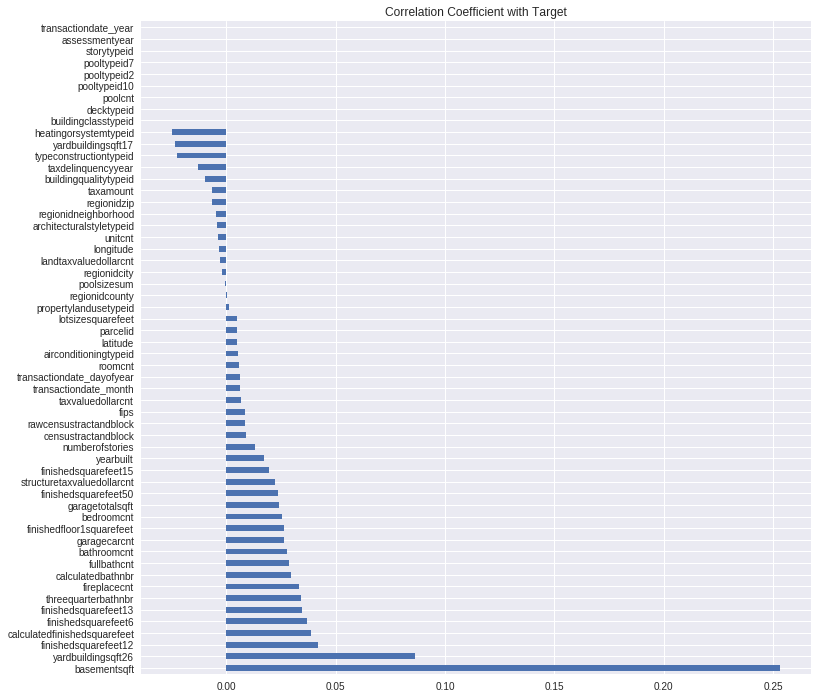

In [4]:
full_report(train_df, target_column='logerror')